# Data generation
Generates data for a desired date based on the available APC data and passed through the model for load prediction.
## Generates the following files:
* `trip_plan.json`
* `vehicle_plan.json`
* `sampled_loads.pkl`
* `chains.pkl`

In [1]:
from tensorflow.keras import backend as K
K.clear_session()
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import datetime as dt
import importlib
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql import functions as F
from pyspark import SparkConf
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Model
import IPython
from copy import deepcopy
from tqdm import trange, tqdm

mpl.rcParams['figure.facecolor'] = 'white'

import warnings

import pandas as pd
import swifter
pd.set_option('display.max_columns', None)
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.get_logger().setLevel('INFO')
import pyspark
print(pyspark.__version__)
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()

3.3.0
22/10/24 16:56:32 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/10/24 16:56:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/24 16:56:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/24 16:56:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/24 16:56:33 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [6]:
def get_apc_data_for_date(filter_date):
    print("Running this...")
    filepath = '/home/jptalusan/mta_stationing_problem/data/processed/apc_weather_gtfs_20220921.parquet'
    apcdata = spark.read.load(filepath)
    apcdata.createOrReplaceTempView("apc")

    plot_date = filter_date.strftime('%Y-%m-%d')
    get_columns = ['trip_id', 'transit_date', 'arrival_time', 
                'block_abbr', 'stop_sequence', 'stop_id_original',
                'load', 
                'darksky_temperature', 
                'darksky_humidity', 
                'darksky_precipitation_probability', 
                'route_direction_name', 'route_id',
                'dayofweek',  'year', 'month', 'hour', 'zero_load_at_trip_end',
                'sched_hdwy']
    get_str = ", ".join([c for c in get_columns])
    query = f"""
    SELECT {get_str}
    FROM apc
    WHERE (transit_date == '{plot_date}')
    ORDER BY arrival_time
    """
    apcdata = spark.sql(query)
    apcdata = apcdata.withColumn("route_id_dir", F.concat_ws("_", apcdata.route_id, apcdata.route_direction_name))
    apcdata = apcdata.withColumn("day", F.dayofmonth(apcdata.arrival_time))
    apcdata = apcdata.drop("route_direction_name")
    apcdata = apcdata.withColumn("load", F.when(apcdata.load < 0, 0).otherwise(apcdata.load))
    apcdata = apcdata.na.fill(value=0,subset=["zero_load_at_trip_end"])
    return apcdata

In [19]:
def prepare_input_data(input_df, ohe_encoder, label_encoders, num_scaler, columns, keep_columns=[], target='y_class'):
    num_columns = ['darksky_temperature', 'darksky_humidity', 'darksky_precipitation_probability', 'sched_hdwy']
    cat_columns = ['month', 'hour', 'day', 'stop_sequence', 'stop_id_original', 'year', 'time_window']
    ohe_columns = ['dayofweek', 'route_id_dir', 'is_holiday', 'is_school_break', 'zero_load_at_trip_end']

    # OHE
    input_df[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(input_df[ohe_columns]).toarray()
    # input_df = input_df.drop(columns=ohe_columns)

    # Label encoder
    for cat in cat_columns:
        encoder = label_encoders[cat]
        input_df[cat] = encoder.transform(input_df[cat])
    
    # Num scaler
    input_df[num_columns] = num_scaler.transform(input_df[num_columns])
    input_df['y_class']  = input_df.y_class.astype('int')

    if keep_columns:
        columns = keep_columns + columns
    # Rearrange columns
    input_df = input_df[columns]
    
    return input_df

def assign_data_to_bins(df, TARGET='load'):
    bins = pd.IntervalIndex.from_tuples([(-1, 6.0), (6.0, 12.0), (12.0, 55.0), (55.0, 75.0), (75.0, 100.0)])
    mycut = pd.cut(df[TARGET].tolist(), bins=bins)
    df['y_class'] = mycut.codes
    return df

In [20]:
TIMEWINDOW = 15
def add_features(df):
    df = df[df.arrival_time.notna()]
    df = df.fillna(method="bfill")

    df['day'] = df["arrival_time"].dt.day
    df = df.sort_values(by=['block_abbr', 'arrival_time']).reset_index(drop=True)

    # Adding extra features
    # Holidays
    fp = os.path.join('data', 'US Holiday Dates (2004-2021).csv')
    holidays_df = pd.read_csv(fp)
    holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
    holidays_df['is_holiday'] = True
    df = df.merge(holidays_df[['Date', 'is_holiday']], left_on='transit_date', right_on='Date', how='left')
    df['is_holiday'] = df['is_holiday'].fillna(False)
    df = df.drop(columns=['Date'])
        
    # School breaks
    fp = os.path.join('data', 'School Breaks (2019-2022).pkl')
    school_break_df = pd.read_pickle(fp)
    school_break_df['is_school_break'] = True
    df = df.merge(school_break_df[['Date', 'is_school_break']], left_on='transit_date', right_on='Date', how='left')
    df['is_school_break'] = df['is_school_break'].fillna(False)
    df = df.drop(columns=['Date'])

    df['minute'] = df['arrival_time'].dt.minute
    df['minuteByWindow'] = df['minute'] // TIMEWINDOW
    df['temp'] = df['minuteByWindow'] + (df['hour'] * 60 / TIMEWINDOW)
    df['time_window'] = np.floor(df['temp']).astype('int')
    df = df.drop(columns=['minute', 'minuteByWindow', 'temp'])

    # HACK
    df = df[df['hour'] != 3]
    df = df[df['stop_sequence'] != 0]

    df = df.sort_values(by=['block_abbr', 'arrival_time']).reset_index(drop=True)

    df = assign_data_to_bins(df, TARGET='load')
    return df

In [21]:
def setup_simple_lstm_generator(num_features, num_classes, learning_rate=1e-4):
    # define model
    model = tf.keras.Sequential()
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # compile model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["sparse_categorical_accuracy"],
    )

    input_shape = (None, None, num_features)
    model.build(input_shape)
    return model

def generate_simple_lstm_predictions(input_df, model, past, future):
    past_df = input_df[0:past]
    future_df = input_df[past:]
    predictions = []
    pred_probs = []
    if future == None:
        future = len(future_df)
    for f in range(future):
        pred = model.predict(past_df.to_numpy().reshape(1, *past_df.shape))
        print(pred)
        pred_probs.append(pred)
        y_pred = np.argmax(pred)
        predictions.append(y_pred)
        
        # Add information from future
        last_row = future_df.iloc[[0]]
        last_row['y_class'] = y_pred
        past_df = pd.concat([past_df[1:], last_row])
        
        # Move future to remove used row
        future_df = future_df[1:]
    return predictions, pred_probs

In [22]:
# Load model
latest = tf.train.latest_checkpoint('models/no_speed')
columns = joblib.load('models/LL_X_columns.joblib')
label_encoders = joblib.load('models/LL_Label_encoders.joblib')
ohe_encoder = joblib.load('models/LL_OHE_encoder.joblib')
num_scaler = joblib.load('models/LL_Num_scaler.joblib')

DATE = '2021-05-23'
date_to_predict = dt.datetime.strptime(DATE, '%Y-%m-%d')
apcdata = get_apc_data_for_date(date_to_predict)
df = apcdata.toPandas()
df = add_features(df)

raw_df = deepcopy(df)
input_df = prepare_input_data(df, ohe_encoder, label_encoders, num_scaler, columns, target='y_class')

ohe_columns = ['dayofweek', 'route_id_dir', 'is_holiday', 'is_school_break', 'zero_load_at_trip_end']
input_df = input_df.drop(columns=ohe_columns)

Running this...


In [23]:
input_df

,y_class,stop_id_original,time_window,year,month,day,hour,stop_sequence,darksky_temperature,darksky_humidity,darksky_precipitation_probability,sched_hdwy,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,route_id_dir_14_FROM DOWNTOWN,route_id_dir_14_TO DOWNTOWN,route_id_dir_17_FROM DOWNTOWN,route_id_dir_17_TO DOWNTOWN,route_id_dir_18_FROM DOWNTOWN,route_id_dir_18_TO DOWNTOWN,route_id_dir_19_FROM DOWNTOWN,route_id_dir_19_TO DOWNTOWN,route_id_dir_21_NORTHBOUND,route_id_dir_21_SOUTHBOUND,route_id_dir_22_FROM DOWNTOWN,route_id_dir_22_TO DOWNTOWN,route_id_dir_23_FROM DOWNTOWN,route_id_dir_23_TO DOWNTOWN,route_id_dir_24_FROM DOWNTOWN,route_id_dir_24_TO DOWNTOWN,route_id_dir_25_NORTHBOUND,route_id_dir_25_SOUTHBOUND,route_id_dir_28_FROM DOWNTOWN,route_id_dir_28_TO DOWNTOWN,route_id_dir_29_FROM DOWNTOWN,route_id_dir_29_TO DOWNTOWN,route_id_dir_34_FROM DOWNTOWN,route_id_dir_34_TO DOWNTOWN,route_id_dir_35_FROM DOWNTOWN,route_id_dir_35_TO DOWNTOWN,route_id_dir_38_FROM DOWNTOWN,route_id_dir_38_TO DOWNTOWN,route_id_dir_3_FROM DOWNTOWN,route_id_dir_3_TO DOWNTOWN,route_id_dir_41_FROM DOWNTOWN,route_id_dir_41_TO DOWNTOWN,route_id_dir_42_FROM DOWNTOWN,route_id_dir_42_TO DOWNTOWN,route_id_dir_43_FROM DOWNTOWN,route_id_dir_43_TO DOWNTOWN,route_id_dir_4_FROM DOWNTOWN,route_id_dir_4_TO DOWNTOWN,route_id_dir_50_FROM DOWNTOWN,route_id_dir_50_TO DOWNTOWN,route_id_dir_52_FROM DOWNTOWN,route_id_dir_52_TO DOWNTOWN,route_id_dir_55_FROM DOWNTOWN,route_id_dir_55_TO DOWNTOWN,route_id_dir_56_FROM DOWNTOWN,route_id_dir_56_TO DOWNTOWN,route_id_dir_5_FROM DOWNTOWN,route_id_dir_5_TO DOWNTOWN,route_id_dir_64_FROM RIVERFRONT,route_id_dir_64_TO RIVERFRONT,route_id_dir_6_FROM DOWNTOWN,route_id_dir_6_TO DOWNTOWN,route_id_dir_72_EDMONDSON,route_id_dir_72_GRASSMERE,route_id_dir_75_NORTHBOUND,route_id_dir_75_SOUTHBOUND,route_id_dir_76_LOOP,route_id_dir_79_EASTBOUND,route_id_dir_79_NORTHBOUND,route_id_dir_7_FROM DOWNTOWN,route_id_dir_7_TO DOWNTOWN,route_id_dir_84_FROM NASHVILLE,route_id_dir_84_TO NASHVILLE,route_id_dir_86_FROM NASHVILLE,route_id_dir_86_TO NASHVILLE,route_id_dir_8_FROM DOWNTOWN,route_id_dir_8_TO DOWNTOWN,route_id_dir_93_LOOP,route_id_dir_94_FROM NASHVILLE,route_id_dir_95_FROM NASHVILLE,route_id_dir_96_FROM NASHVILLE,route_id_dir_96_TO NASHVILLE,route_id_dir_9_FROM DOWNTOWN,route_id_dir_9_TO DOWNTOWN,is_holiday_False,is_holiday_True,is_school_break_False,is_school_break_True,zero_load_at_trip_end_0,zero_load_at_trip_end_1
0,0,1976,15,1,4,22,4,0,0.633212,0.96250,0.0,0.041710,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0,1978,15,1,4,22,4,1,0.633212,0.96250,0.0,0.020855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0,1985,15,1,4,22,4,2,0.633212,0.96250,0.0,0.020855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0,1987,15,1,4,22,4,3,0.633212,0.96250,0.0,0.020855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

100%|██████████| 1/1 [00:00<00:00, 153.41it/s]


,y_class,stop_id_original,time_window,year,month,day,hour,stop_sequence,darksky_temperature,darksky_humidity,darksky_precipitation_probability,sched_hdwy,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,route_id_dir_14_FROM DOWNTOWN,route_id_dir_14_TO DOWNTOWN,route_id_dir_17_FROM DOWNTOWN,route_id_dir_17_TO DOWNTOWN,route_id_dir_18_FROM DOWNTOWN,route_id_dir_18_TO DOWNTOWN,route_id_dir_19_FROM DOWNTOWN,route_id_dir_19_TO DOWNTOWN,route_id_dir_21_NORTHBOUND,route_id_dir_21_SOUTHBOUND,route_id_dir_22_FROM DOWNTOWN,route_id_dir_22_TO DOWNTOWN,route_id_dir_23_FROM DOWNTOWN,route_id_dir_23_TO DOWNTOWN,route_id_dir_24_FROM DOWNTOWN,route_id_dir_24_TO DOWNTOWN,route_id_dir_25_NORTHBOUND,route_id_dir_25_SOUTHBOUND,route_id_dir_28_FROM DOWNTOWN,route_id_dir_28_TO DOWNTOWN,route_id_dir_29_FROM DOWNTOWN,route_id_dir_29_TO DOWNTOWN,route_id_dir_34_FROM DOWNTOWN,route_id_dir_34_TO DOWNTOWN,route_id_dir_35_FROM DOWNTOWN,route_id_dir_35_TO DOWNTOWN,route_id_dir_38_FROM DOWNTOWN,route_id_dir_38_TO DOWNTOWN,route_id_dir_3_FROM DOWNTOWN,route_id_dir_3_TO DOWNTOWN,route_id_dir_41_FROM DOWNTOWN,route_id_dir_41_TO DOWNTOWN,route_id_dir_42_FROM DOWNTOWN,route_id_dir_42_TO DOWNTOWN,route_id_dir_43_FROM DOWNTOWN,route_id_dir_43_TO DOWNTOWN,route_id_dir_4_FROM DOWNTOWN,route_id_dir_4_TO DOWNTOWN,route_id_dir_50_FROM DOWNTOWN,route_id_dir_50_TO DOWNTOWN,route_id_dir_52_FROM DOWNTOWN,route_id_dir_52_TO DOWNTOWN,route_id_dir_55_FROM DOWNTOWN,route_id_dir_55_TO DOWNTOWN,route_id_dir_56_FROM DOWNTOWN,route_id_dir_56_TO DOWNTOWN,route_id_dir_5_FROM DOWNTOWN,route_id_dir_5_TO DOWNTOWN,route_id_dir_64_FROM RIVERFRONT,route_id_dir_64_TO RIVERFRONT,route_id_dir_6_FROM DOWNTOWN,route_id_dir_6_TO DOWNTOWN,route_id_dir_72_EDMONDSON,route_id_dir_72_GRASSMERE,route_id_dir_75_NORTHBOUND,route_id_dir_75_SOUTHBOUND,route_id_dir_76_LOOP,route_id_dir_79_EASTBOUND,route_id_dir_79_NORTHBOUND,route_id_dir_7_FROM DOWNTOWN,route_id_dir_7_TO DOWNTOWN,route_id_dir_84_FROM NASHVILLE,route_id_dir_84_TO NASHVILLE,route_id_dir_86_FROM NASHVILLE,route_id_dir_86_TO NASHVILLE,route_id_dir_8_FROM DOWNTOWN,route_id_dir_8_TO DOWNTOWN,route_id_dir_93_LOOP,route_id_dir_94_FROM NASHVILLE,route_id_dir_95_FROM NASHVILLE,route_id_dir_96_FROM NASHVILLE,route_id_dir_96_TO NASHVILLE,route_id_dir_9_FROM DOWNTOWN,route_id_dir_9_TO DOWNTOWN,is_holiday_False,is_holiday_True,is_school_break_False,is_school_break_True,zero_load_at_trip_end_0,zero_load_at_trip_end_1
0,0,1976,15,1,4,22,4,0,0.633212,0.9625,0.0,0.041710,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0,1978,15,1,4,22,4,1,0.633212,0.9625,0.0,0.020855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0,1985,15,1,4,22,4,2,0.633212,0.9625,0.0,0.020855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0,1987,15,1,4,22,4,3,0.633212,0.9625,0.0,0.020855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

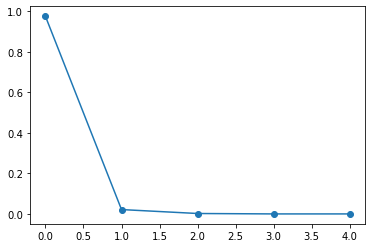

In [28]:
import random
past = 5
rand_trips = random.sample(df.trip_id.unique().tolist(), 1)
for trip_id in tqdm(rand_trips):
    _df = df.query("trip_id == @trip_id")
    try:
        _input_df = input_df.loc[_df.index]
    except:
        pass
past_df = input_df[0:past]
future_df = input_df[past:]

display(past_df)
model = setup_simple_lstm_generator(input_df.shape[1], 5)
model.load_weights(latest)
# model.summary()
res = model.predict(past_df.to_numpy().reshape(1, *past_df.shape))

plt.plot(res.flatten(), marker='o')

In [29]:
import random

percentiles = [(0, 6.0), (6.0, 12.0), (12.0, 55.0), (55.0, 75.0), (75.0, 100.0)]

NUM_CLASSES = 5
FUTURE = None
PAST = 5

NUM_TRIPS = 10
if NUM_TRIPS == None:
    rand_trips = df.trip_id.unique().tolist()
else:
    rand_trips = random.sample(df.trip_id.unique().tolist(), NUM_TRIPS)

model = setup_simple_lstm_generator(input_df.shape[1], NUM_CLASSES)
model.load_weights(latest)

trip_res = []
load_arr = []
for trip_id in tqdm(rand_trips):
    _df = df.query("trip_id == @trip_id")
    try:
        _input_df = input_df.loc[_df.index]
        y_pred, y_pred_probs = generate_simple_lstm_predictions(_input_df, model, PAST, FUTURE)
        loads = [random.randint(percentiles[yp][0], percentiles[yp][1]) for yp in y_pred]
        
        _raw_df = raw_df.loc[_df.index]
        y_true = _raw_df[0:PAST]['load'].tolist()
        a = y_true + loads
        _raw_df['sampled_loads'] = a
        
        y_true_classes = _raw_df[0:PAST]['y_class'].tolist()
        _raw_df['y_pred_classes'] = y_true_classes + y_pred
        _raw_df['y_pred_probs'] = [-1]*len(y_true_classes) + y_pred_probs
        
        trip_res.append(_raw_df)
    except:
        print(f"FAILED:{trip_id}")
        continue

trip_res = pd.concat(trip_res)

  0%|          | 0/10 [00:00<?, ?it/s]

[[9.8168373e-01 1.6510056e-02 1.8063193e-03 6.1407518e-11 2.1848807e-18]]
[[9.8163074e-01 1.6491117e-02 1.8781495e-03 7.1878122e-11 2.8720683e-18]]
[[9.8173243e-01 1.6487446e-02 1.7801169e-03 6.0230702e-11 2.3175039e-18]]
[[9.7975928e-01 1.8134832e-02 2.1058021e-03 1.1786352e-10 7.2697049e-18]]
[[9.80125964e-01 1.78029146e-02 2.07106257e-03 1.13832735e-10
  6.90870512e-18]]
[[9.80798900e-01 1.72065534e-02 1.99457398e-03 1.05597586e-10
  6.39784747e-18]]
[[9.9203402e-01 6.8673636e-03 1.0985932e-03 1.7936952e-11 2.4958337e-19]]
[[9.4386673e-01 4.7139145e-02 8.9940829e-03 3.1586051e-08 1.5238883e-13]]
[[7.8496593e-01 1.6581231e-01 4.9209617e-02 1.2138838e-05 8.9668646e-09]]
[[9.4016701e-01 4.5403838e-02 1.4428931e-02 3.0054781e-07 5.4693121e-12]]
[[9.59745765e-01 3.03158555e-02 9.93838534e-03 4.05812735e-08
  1.11935357e-13]]
[[9.82267976e-01 1.36417523e-02 4.09031147e-03 1.37789069e-09
  1.05333285e-16]]
[[9.7997588e-01 1.4490087e-02 5.5340710e-03 6.5917183e-09 5.1686454e-15]]
[[9.671690

 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[[9.9891269e-01 9.1410201e-04 1.7321811e-04 4.7480283e-14 5.6643834e-24]]
[[3.2897357e-02 9.4780642e-01 1.9294674e-02 1.4843934e-06 8.7974933e-10]]
[[3.0053267e-02 9.5503324e-01 1.4912834e-02 6.6337299e-07 2.7744143e-10]]
[[2.84091271e-02 9.60644186e-01 1.09464135e-02 3.06167436e-07
  8.68438169e-11]]
[[3.6519237e-02 9.5120311e-01 1.2277183e-02 4.4719653e-07 1.5000599e-10]]
[[3.3075042e-02 9.5595157e-01 1.0973002e-02 3.6841155e-07 1.2016289e-10]]
[[3.5781551e-02 9.5358890e-01 1.0629235e-02 3.5928616e-07 1.1727763e-10]]
[[3.9842289e-02 9.4870919e-01 1.1447966e-02 4.9031684e-07 1.9359254e-10]]
[[3.71471792e-02 9.52829063e-01 1.00234393e-02 3.41359936e-07
  1.11283045e-10]]
[[4.1885152e-02 9.4798625e-01 1.0128226e-02 3.8287527e-07 1.3649760e-10]]
[[4.2811453e-02 9.4728547e-01 9.9027064e-03 3.8172303e-07 1.3713337e-10]]
[[4.6760090e-02 9.4315773e-01 1.0081790e-02 4.2579808e-07 1.6859730e-10]]
[[4.9327135e-02 9.4035035e-01 1.0322017e-02 4.7077296e-07 1.9736193e-10]]
[[4.8494767e-02 9.418230

 30%|███       | 3/10 [00:02<00:05,  1.29it/s]

[[4.5364824e-01 4.6473980e-01 8.1594601e-02 1.7195602e-05 2.5706640e-07]]
[[2.3303729e-01 7.3453736e-01 3.2400012e-02 2.5279069e-05 7.9463668e-08]]
[[1.1341282e-01 8.6035895e-01 2.6210153e-02 1.8126468e-05 3.8887940e-08]]
[[6.2471218e-02 9.1623324e-01 2.1293387e-02 2.1743722e-06 1.4429985e-09]]
[[5.9304353e-02 9.2264438e-01 1.8049926e-02 1.3667096e-06 7.4783973e-10]]
[[6.8157874e-02 9.1321397e-01 1.8626466e-02 1.7346518e-06 1.0695662e-09]]
[[6.6049770e-02 9.1683358e-01 1.7115289e-02 1.4037863e-06 8.1630086e-10]]
[[7.4453749e-02 9.0860939e-01 1.6935416e-02 1.4409607e-06 8.7655977e-10]]
[[7.0337877e-02 9.1403693e-01 1.5624009e-02 1.1546807e-06 6.3527550e-10]]
[[7.6219574e-02 9.0879768e-01 1.4981668e-02 1.0328505e-06 5.5691141e-10]]
[[9.1911338e-02 8.9068598e-01 1.7400483e-02 2.2523188e-06 2.3414837e-09]]
[[1.2097787e-01 8.5688502e-01 2.2130981e-02 6.0148536e-06 1.5183311e-08]]
[[1.2185447e-01 8.5726458e-01 2.0876495e-02 4.5007746e-06 9.2548929e-09]]
[[1.1634055e-01 8.6448365e-01 1.917241

 40%|████      | 4/10 [00:03<00:04,  1.35it/s]

[[3.9469682e-02 9.5237893e-01 8.1511373e-03 2.4668370e-07 6.3257045e-11]]
[[6.8004526e-02 9.1972667e-01 1.2267448e-02 1.3527475e-06 1.5859253e-09]]
[[7.5747326e-02 9.1467410e-01 9.5780669e-03 4.5005453e-07 2.0779448e-10]]
[[9.8413163e-01 1.3941697e-02 1.9267524e-03 7.6875478e-11 2.0562817e-18]]
[[9.8446596e-01 1.3783965e-02 1.7500031e-03 7.3081242e-11 2.6392308e-18]]
[[9.8619497e-01 1.2407877e-02 1.3971120e-03 3.3428666e-11 6.7726778e-19]]
[[9.8617482e-01 1.2419722e-02 1.4053901e-03 3.4342914e-11 7.0049232e-19]]
[[9.8652399e-01 1.2103668e-02 1.3723660e-03 3.2345959e-11 6.3986184e-19]]
[[9.8662508e-01 1.2005245e-02 1.3696422e-03 3.2966421e-11 6.6643786e-19]]
[[9.8659825e-01 1.2016625e-02 1.3851683e-03 3.5572777e-11 7.7404310e-19]]
[[9.8672360e-01 1.1897942e-02 1.3784504e-03 3.6643476e-11 8.3268974e-19]]
[[9.8663539e-01 1.1965777e-02 1.3988374e-03 4.1172826e-11 1.0595742e-18]]
[[9.86551404e-01 1.20345345e-02 1.41412602e-03 4.60073958e-11
  1.33680194e-18]]
[[9.8629284e-01 1.2251906e-02 1

 50%|█████     | 5/10 [00:04<00:04,  1.21it/s]

[[9.8709655e-01 1.1372213e-02 1.5312219e-03 1.5791136e-10 1.2533586e-17]]
[[9.8942494e-01 9.4531504e-03 1.1219530e-03 4.7313608e-11 1.5864108e-18]]
[[9.8670292e-01 1.1729053e-02 1.5680463e-03 1.8082054e-10 1.7372007e-17]]
[[9.7669345e-01 1.9814294e-02 3.4921973e-03 3.4571328e-09 2.7529587e-15]]
[[9.7941989e-01 1.7187582e-02 3.3925984e-03 2.1291162e-09 8.6018398e-16]]
[[9.6811956e-01 2.5875516e-02 6.0049370e-03 1.5373901e-08 2.4421261e-14]]
[[9.6589327e-01 2.7292522e-02 6.8141147e-03 2.5637309e-08 5.7234321e-14]]
[[9.6188015e-01 3.4382895e-02 3.7369838e-03 9.3205610e-10 2.6462479e-16]]
[[9.6169162e-01 3.4568541e-02 3.7399251e-03 9.4121766e-10 2.6973865e-16]]
[[9.6196067e-01 3.4323636e-02 3.7157158e-03 9.3147845e-10 2.6543556e-16]]
[[9.6377420e-01 3.2627638e-02 3.5981510e-03 8.5999824e-10 2.3206236e-16]]
[[9.6845132e-01 2.8258547e-02 3.2901992e-03 6.7722833e-10 1.5384096e-16]]
[[9.6439481e-01 3.2104827e-02 3.5002891e-03 7.9759932e-10 2.0230164e-16]]
[[9.7533756e-01 2.1775153e-02 2.887348

 70%|███████   | 7/10 [00:05<00:01,  1.58it/s]

[[9.9526370e-01 4.1847969e-03 5.5145472e-04 2.5774625e-12 5.0038575e-21]]
[[9.9855071e-01 1.3206284e-03 1.2866425e-04 1.1541319e-14 3.6708126e-25]]
[[9.8933077e-01 8.3843665e-03 2.2848304e-03 3.2857136e-10 3.3114277e-17]]
[[9.4144416e-01 4.2910896e-02 1.5644766e-02 1.9868813e-07 1.1612669e-12]]
[[9.7567219e-01 1.9971117e-02 4.3567023e-03 2.9557878e-09 6.5731318e-16]]
[[1.9004722e-03 1.3102640e-02 9.8392510e-01 1.0117368e-03 6.0065762e-05]]
[[2.3470477e-03 1.4694420e-02 9.8190272e-01 9.9835463e-04 5.7475558e-05]]
[[2.4627300e-03 1.5329665e-02 9.8122442e-01 9.3050342e-04 5.2746833e-05]]
[[3.0585614e-03 1.7480033e-02 9.7816867e-01 1.2181181e-03 7.4703254e-05]]
[[3.3307876e-03 1.8199814e-02 9.7722960e-01 1.1690654e-03 7.0820483e-05]]
[[4.0024067e-03 1.9662727e-02 9.7489023e-01 1.3586747e-03 8.5930187e-05]]
[[4.4198046e-03 2.0574849e-02 9.7360051e-01 1.3223190e-03 8.2470149e-05]]
[[4.7332793e-03 2.1625506e-02 9.7234398e-01 1.2234461e-03 7.3719901e-05]]
[[5.2970462e-03 2.3157485e-02 9.702221

 80%|████████  | 8/10 [00:05<00:01,  1.47it/s]

[[0.23761271 0.16480906 0.5724515  0.02113846 0.00398834]]
[[0.07968814 0.052571   0.8276758  0.03417052 0.00589446]]
[[9.8710120e-01 1.1840183e-02 1.0585762e-03 8.8238479e-12 5.7499722e-20]]
[[9.9104077e-01 8.3368123e-03 6.2253850e-04 2.1835277e-12 5.8575014e-21]]
[[9.7788870e-01 2.0084394e-02 2.0268073e-03 2.0141752e-10 1.8105336e-17]]
[[9.5819193e-01 3.6065925e-02 5.7420745e-03 5.4119917e-09 4.7787032e-15]]
[[9.7275680e-01 2.4202205e-02 3.0409854e-03 6.1346384e-10 1.0556955e-16]]
[[9.8757523e-01 1.1333993e-02 1.0907514e-03 1.2752683e-11 1.5101723e-19]]
[[9.7240257e-01 2.5025195e-02 2.5722350e-03 3.0736846e-10 4.9955399e-17]]
[[9.6804899e-01 2.8545683e-02 3.4053635e-03 8.0393286e-10 2.5470458e-16]]
[[9.6573311e-01 3.0526238e-02 3.7405721e-03 1.1588170e-09 4.9609952e-16]]
[[9.6679348e-01 2.9574808e-02 3.6316300e-03 1.0994845e-09 4.5712711e-16]]
[[9.6631038e-01 3.0006552e-02 3.6830651e-03 1.2311832e-09 5.7888206e-16]]
[[9.6462858e-01 3.1456120e-02 3.9153225e-03 1.6427975e-09 9.4927131e

 90%|█████████ | 9/10 [00:06<00:00,  1.29it/s]

[[9.6441054e-01 3.1980015e-02 3.6093693e-03 1.9820021e-09 1.3659017e-15]]
[[9.5731568e-01 3.8262874e-02 4.4214227e-03 4.0475334e-09 4.7980139e-15]]
[[9.4641030e-01 4.7209114e-02 6.3805520e-03 1.7354667e-08 6.0638059e-14]]
[[9.6268511e-01 3.2984387e-02 4.3305587e-03 2.9788136e-09 2.1843339e-15]]
[[9.1787118e-01 7.1262203e-02 1.0866512e-02 1.0914951e-07 1.4786210e-12]]
[[9.5963544e-01 3.5176232e-02 5.1883804e-03 5.9281526e-09 6.9970770e-15]]
[[9.0946168e-01 8.0589607e-02 9.9486057e-03 5.4353809e-08 3.4233448e-13]]


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


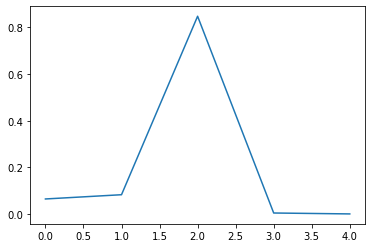

In [31]:
plt.plot([6.4473554e-02, 8.2699254e-02, 8.4818405e-01, 4.2822519e-03, 3.6081712e-04])

In [ ]:
_columns = ['trip_id', 'transit_date', 'arrival_time', 'scheduled_time', 'vehicle_id', 'vehicle_capacity', 'block_abbr', 'stop_sequence', 'stop_id_original', 'route_id_dir', 'zero_load_at_trip_end', 'y_pred_classes', 'sampled_loads']
trip_res = trip_res[_columns]

# fp = 'results/sampled_loads.pkl'
# trip_res.to_pickle(fp)

In [ ]:
# 9300, MCSRVRF, 2021-08-23 06:37:00, 93_LOOP, 0
trip_res.query("trip_id == '243425'").head()

In [ ]:
# 9300, MCSRVRF, 2021-08-23 06:37:00, 93_LOOP, 0
raw_df.query("trip_id == '243425'").head()

## Generate vehicle assignments here...

In [ ]:
import json
# Vehicle assignments
# Each vehicle config is a dict: {vehicle_capacity, blocks}
DEFAULT_CAPACITY = 40.0
overall_vehicle_plan = {}

# TODO: run again with vehicle_capacity (above)
for vehicle_id, vehicle_df in trip_res.groupby('vehicle_id'):
    vehicle_df = vehicle_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    vehicle_capacity = vehicle_df.iloc[0].vehicle_capacity
    # vehicle_capacity = DEFAULT_CAPACITY
    if np.isnan(vehicle_capacity):
        vehicle_capacity = DEFAULT_CAPACITY
    # TODO: This is not the baseline behavior
    starting_depot = 'MCC5_1'
    service_type = 'regular'
    blocks = [block for block in vehicle_df.block_abbr.unique().tolist()]
    trips = []
    for block in blocks:
        block_df = vehicle_df.query("block_abbr == @block")
        for trip in block_df.trip_id.unique().tolist():
            trips.append((str(block), str(trip)))
    overall_vehicle_plan[vehicle_id] = {'vehicle_capacity': vehicle_capacity, 'trips': trips, 'starting_depot': starting_depot, 'service_type': service_type}
    
len(overall_vehicle_plan)

# Number of overload buses
#   "42": {
#     "service_type": "overload",
#     "starting_depot": "MCC5_1",
#     "trips": [
#     ],
#     "vehicle_capacity": 55.0
#   }
OVERLOAD_BUSES = 2
for vehicle_id in range(41, 41 + OVERLOAD_BUSES):
    overall_vehicle_plan[str(vehicle_id)] = {'vehicle_capacity': 55.0, 'trips': [], "starting_depot": "MCC5_1", 'service_type': "overload"}
    
with open('results/vehicle_plan.json', 'w') as fp:
    json.dump(overall_vehicle_plan, fp, sort_keys=True, indent=2)

## Setting up Trip plan (sanity check)

In [ ]:
# Create a dict of {[block: {trip_ids:[]}, 'block'....]}
# trip_id dict = {'route_id', route_direction_name', 'stop_id':[], 'schedule_time':[]}
# Use block as grouper in baseline
overall_block_plan = {}
for block_abbr, block_df in trip_res.groupby('block_abbr'):
    block_df = block_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    trip_ids = block_df.trip_id.unique().tolist()
    start_time = block_df[block_df['trip_id'] == trip_ids[0]].iloc[0]['scheduled_time'].strftime('%Y-%m-%d %H:%M:%S')
    end_time = block_df[block_df['trip_id'] == trip_ids[-1]].iloc[-1]['scheduled_time'].strftime('%Y-%m-%d %H:%M:%S')
    overall_block_plan[block_abbr] = {'trip_ids': trip_ids,
                                      'start_time': start_time,
                                      'end_time': end_time}

overall_trip_plan = {}
for trip_id, trip_df in trip_res.groupby('trip_id'):
    trip_df = trip_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    route_id_dir = trip_df.iloc[0].route_id_dir
    route_id = int(route_id_dir.split("_")[0])
    route_direction = route_id_dir.split("_")[1]
    zero_load_at_trip_end = trip_df.iloc[-1].zero_load_at_trip_end.tolist()
    scheduled_time = trip_df.scheduled_time.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    stop_sequence = trip_df.stop_sequence.tolist()
    stop_sequence = list(range(0, len(stop_sequence)))
    # stop_sequence = [ss - 1 for ss in stop_sequence]
    stop_id_original = trip_df.stop_id_original.tolist()
    
    overall_trip_plan[trip_id] = {'route_id': route_id, 
                                  'route_direction': route_direction, 
                                  'scheduled_time': scheduled_time, 
                                  'stop_sequence': stop_sequence, 
                                  'stop_id_original': stop_id_original,
                                  'zero_load_at_trip_end':zero_load_at_trip_end,
                                  'last_stop_sequence': stop_sequence[-1],
                                  'last_stop_id': stop_id_original[-1]}

len(overall_trip_plan), len(overall_block_plan)

with open('results/trip_plan.json', 'w') as fp:
    json.dump(overall_trip_plan, fp, sort_keys=True, indent=2)

In [ ]:
display(trip_res.query("trip_id == '246303'"))
print(trip_res.query("trip_id == '246303'").shape)

In [ ]:
raw_df.query("trip_id == '243423'").shape

In [ ]:
route_id_dir = 
trip_res.query("route_id_dir == @route_id_dir and block_abbr == @block and stop_id_original == @stop_id_original[@i] and scheduled_time == @scheduled_time[@i]").iloc[0]['sampled_loads']

## Getting ons and offs from sampled loads

In [ ]:
import pandas as pd

def compute_ons_offs(s):
    curr_load = s['sampled_loads']
    next_load = s['next_load']
    if next_load > curr_load:
        ons = next_load - curr_load
        offs = 0
    elif next_load < curr_load:
        ons = 0
        offs = curr_load - next_load
    else:
        ons = 0
        offs = 0
        
    return ons, offs
    
fp = 'results/sampled_loads.pkl'
trip_res = pd.read_pickle(fp)
sampled_ons_offs = []
for trip_id, trip_id_df in tqdm(trip_res.groupby(['transit_date', 'trip_id'])):
    tdf = trip_id_df.sort_values('stop_sequence').reset_index(drop=True)
    tdf['ons'] = 0
    tdf['offs'] = 0
    tdf['next_load'] = tdf['sampled_loads'].shift(-1)
    
    # Intermediate stops
    tdf[['ons', 'offs']] = tdf.apply(compute_ons_offs, axis=1, result_type="expand")
    
    # first and last stops
    tdf.at[0, 'ons'] = tdf.iloc[0]['sampled_loads']
    tdf.at[len(tdf) - 1, 'offs'] = tdf.iloc[-1]['sampled_loads']
    sampled_ons_offs.append(tdf)
    
sampled_ons_offs = pd.concat(sampled_ons_offs)
sampled_ons_offs = sampled_ons_offs.drop('next_load', axis=1)

fp = 'results/sampled_ons_offs.pkl'
sampled_ons_offs.to_pickle(fp)

In [ ]:
sampled_ons_offs.query("trip_id == '246346'")

In [ ]:
sampled_ons_offs.vehicle_id.unique().shape

## Generating a single event chain


In [ ]:
import random
import pandas as pd

def compute_ons_offs(s):
    curr_load = s['sampled_loads']
    next_load = s['next_load']
    if next_load > curr_load:
        ons = next_load - curr_load
        offs = 0
    elif next_load < curr_load:
        ons = 0
        offs = curr_load - next_load
    else:
        ons = 0
        offs = 0
        
    return ons, offs

percentiles = [(0, 6.0), (6.0, 12.0), (12.0, 55.0), (55.0, 75.0), (75.0, 100.0)]
fp = 'results/sampled_loads.pkl'
trip_res = pd.read_pickle(fp)
loads = [random.randint(percentiles[yp][0], percentiles[yp][1]) for yp in trip_res.y_pred_classes]
trip_res['sampled_loads'] = loads

sampled_ons_offs = []
for trip_id, trip_id_df in tqdm(trip_res.groupby(['transit_date', 'trip_id'])):
    tdf = trip_id_df.sort_values('stop_sequence').reset_index(drop=True)
    tdf['stop_sequence'] = list(range(1, len(tdf) + 1))
    tdf['ons'] = 0
    tdf['offs'] = 0
    tdf['next_load'] = tdf['sampled_loads'].shift(-1)
    
    # Intermediate stops
    tdf[['ons', 'offs']] = tdf.apply(compute_ons_offs, axis=1, result_type="expand")
    
    # first and last stops
    tdf.at[0, 'ons'] = tdf.iloc[0]['sampled_loads']
    tdf.at[len(tdf) - 1, 'offs'] = tdf.iloc[-1]['sampled_loads']
    sampled_ons_offs.append(tdf)
    
df = pd.concat(sampled_ons_offs)
df = df.drop('next_load', axis=1)

display(df)
df['key_pair'] = list(zip(df.route_id_dir, 
                          df.block_abbr,
                          df.stop_sequence,
                          df.stop_id_original, 
                          df.scheduled_time))
df = df.set_index('key_pair')
sampled_ons_offs_dict = df.drop(['trip_id', 'route_id_dir', 'block_abbr', 'stop_id_original', 
                                 'scheduled_time', 'transit_date', 'arrival_time', 'vehicle_capacity',
                                 'vehicle_id', 'zero_load_at_trip_end', 'y_pred_classes',
                                 'stop_sequence'], axis=1).to_dict('index')
sampled_ons_offs_dict

import pickle 

with open('results/sampled_ons_offs_dict.pkl', 'wb') as handle:
    pickle.dump(sampled_ons_offs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# df[('23_FROM DOWNTOWN', 2310, 'DWMRT', pd.Timestamp('2021-08-23 05:41:00'))]
df.query("route_id_dir == '23_FROM DOWNTOWN' and block_abbr == 2310 and stop_id_original == 'DWMRT' and scheduled_time == '2021-08-23 05:41:00'")

In [ ]:
sampled_ons_offs_dict[('7_TO DOWNTOWN', 5692, 20, 'MCC5_9', pd.Timestamp('2021-08-23 14:39:00'))]

In [ ]:
# df.query("route_id_dir == '7_TO DOWNTOWN' and block_abbr == 5692 and stop_sequence == 20 and stop_id_original == 'MCC5_9'")
# df.query("route_id_dir == '7_TO DOWNTOWN' and block_abbr == 5692")

## Generating multiple event chains

In [ ]:
import random
import pandas as pd
import pickle
from tqdm import tqdm

def compute_ons_offs(s):
    curr_load = s['sampled_loads']
    next_load = s['next_load']
    if next_load > curr_load:
        ons = next_load - curr_load
        offs = 0
    elif next_load < curr_load:
        ons = 0
        offs = curr_load - next_load
    else:
        ons = 0
        offs = 0
        
    return ons, offs

CHAINS = 5
percentiles = [(0, 6.0), (6.0, 12.0), (12.0, 55.0), (55.0, 75.0), (75.0, 100.0)]

fp = 'results/sampled_loads.pkl'
trip_res = pd.read_pickle(fp)

for chain in tqdm(range(CHAINS)):
    loads = [random.randint(percentiles[yp][0], percentiles[yp][1]) for yp in trip_res.y_pred_classes]
    trip_res['sampled_loads'] = loads

    sampled_ons_offs = []
    for trip_id, trip_id_df in trip_res.groupby(['transit_date', 'trip_id']):
        tdf = trip_id_df.sort_values('stop_sequence').reset_index(drop=True)
        tdf['stop_sequence'] = list(range(1, len(tdf) + 1))
        tdf['ons'] = 0
        tdf['offs'] = 0
        tdf['next_load'] = tdf['sampled_loads'].shift(-1)
        
        # Intermediate stops
        tdf[['ons', 'offs']] = tdf.apply(compute_ons_offs, axis=1, result_type="expand")
        
        # first and last stops
        tdf.at[0, 'ons'] = tdf.iloc[0]['sampled_loads']
        tdf.at[len(tdf) - 1, 'offs'] = tdf.iloc[-1]['sampled_loads']
        sampled_ons_offs.append(tdf)
        
    df = pd.concat(sampled_ons_offs)
    df['key_pair'] = list(zip(df.route_id_dir, 
                            df.block_abbr,
                            df.stop_sequence,
                            df.stop_id_original, 
                            df.scheduled_time))
    df = df.set_index('key_pair')
    sampled_ons_offs_dict = df.drop(['trip_id', 'route_id_dir', 'block_abbr', 'stop_id_original', 
                                    'scheduled_time', 'transit_date', 'arrival_time', 'vehicle_capacity',
                                    'vehicle_id', 'zero_load_at_trip_end', 'y_pred_classes', 'next_load',
                                    'stop_sequence'], axis=1).to_dict('index')

    with open(f'results/chains/ons_offs_dict_chain_{chain}.pkl', 'wb') as handle:
        pickle.dump(sampled_ons_offs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## Sanity check
for chain in range(CHAINS):
    with open(f'results/chains/ons_offs_dict_chain_{chain}.pkl', 'rb') as handle:
        sampled_ons_offs_dict = pickle.load(handle)
    res = sampled_ons_offs_dict[('7_TO DOWNTOWN', 5692, 20, 'MCC5_9', pd.Timestamp('2021-08-23 14:39:00'))]
    print(f"chain {chain}: {res}")

In [ ]:
import datetime as dt
with open(f'results/chains/ons_offs_dict_chain_0.pkl', 'rb') as handle:
    sampled_ons_offs_dict = pickle.load(handle)
# ('7_TO DOWNTOWN', 5692, 1, 'HBHS', datetime.datetime(2021, 8, 23, 14, 9))
# sampled_ons_offs_dict[('7_TO DOWNTOWN', 5692, 1, 'HBHS', dt.datetime(2021, 8, 23, 14, 9))]
search_key = ('7_TO DOWNTOWN', 5692, 5, 'HILLOMNF')
values = [value for key, value in sampled_ons_offs_dict.items() if search_key == key[:len(search_key)]]
keys = [key for key, value in sampled_ons_offs_dict.items() if search_key == key[:len(search_key)]]
values, keys